In [1]:
!pip install sktime
!pip install git+https://github.com/manu-mannattil/nolitsa.git
!pip install giotto-tda 
!pip install scikit-learn
!pip install -U giotto-tda
!pip install ripser
!pip install kmapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 11.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/manu-mannattil/nolitsa.git to /tmp/pip-req-build-erboea_e
  Running command git clone --filter=blob:none --quiet https://github.com/manu-mannattil/nolitsa.git /tmp/pip-req-build-erboea_e
  Resolved https://github.com/manu-mannattil/nolitsa.git to commit 0e3cfd59c82c21c42da55cd24ee944b44aa0d9ad
  Preparing metadata (setup.py) ... done
  Created wheel for nolitsa: filename=nolitsa-0.1-py3-none-any.whl size=22185 sha256=32fe558a4962a26daa4bb9718f477042bbffa88e60ba3a2db0150fa61277de88
  Stored in directory: /tmp/pip-ephem-wheel-cache-hzcx63n6/wheels/0e/f4/40/d6094caec491124c7302bf2741c9d0d9897bb655c18750e12c

In [2]:
import numpy as np
import pandas as pd 
import pickle
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from nolitsa import dimension, delay
import ripser
import persim
import kmapper as km
from kmapper.jupyter import display

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np
import pandas as pd 
SOI=pd.read_excel('/content/gdrive/MyDrive/EA2/SOI.xlsx')
SOI

,YEAR,1,2,3,4,5,6,7,8,9,10,11,12
0,1951,2.5,1.5,-0.2,-0.5,-1.1,0.3,-1.7,-0.4,-1.8,-1.6,-1.3,-1.2
1,1952,-1.5,-1.0,0.9,-0.4,1.2,1.2,0.8,0.1,-0.4,0.6,0.0,-2.0
2,1953,0.5,-0.8,-0.3,0.3,-2.8,0.2,0.0,-2.0,-2.1,0.1,-0.5,-0.8
3,1954,1.1,-0.5,0.4,1.1,0.8,0.2,0.7,1.8,0.3,0.4,0.2,2.3
4,1955,-0.9,3.1,1.1,-0.2,1.7,2.2,2.6,2.4,2.2,2.5,2.0,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2019,-0.1,-2.3,-0.5,0.2,-0.7,-0.7,-0.6,-0.2,-1.9,-0.6,-1.4,-0.9
69,2020,0.3,-0.1,-0.2,0.3,0.7,-0.6,0.7,1.8,1.5,0.8,1.1,3.0
70,2021,3.2,2.5,0.6,0.6,0.8,0.7,2.3,1.0,1.3,1.2,1.6,2.5
71,2022,0.8,1.8,2.9,2.8,2.4,2.8,1.3,1.7,2.7,2.8,0.5,3.5


In [5]:
SOI = pd.melt(SOI, id_vars=['YEAR'])

In [6]:
SOI.sort_values(by=['YEAR','variable'],inplace=True)
SOI = SOI.reset_index(drop=True)
SOI

,YEAR,variable,value
0,1951,1,2.5
1,1951,2,1.5
2,1951,3,-0.2
3,1951,4,-0.5
4,1951,5,-1.1
...,...,...,...
871,2023,8,-999.9
872,2023,9,-999.9
873,2023,10,-999.9
874,2023,11,-999.9


In [7]:
OLR=pd.read_excel('/content/gdrive/MyDrive/EA2/OLR.xlsx', sheet_name='Hoja1')
OLR

,YEAR,1,2,3,4,5,6,7,8,9,10,11,12
0,1974,-999.9,-999.9,-999.9,-999.9,-999.9,61.0,46.2,66.9,68.5,68.9,63.5,39.0
1,1975,32.0,52.0,54.5,48.7,64.1,59.6,64.7,72.8,74.0,73.3,67.5,67.0
2,1976,51.5,53.9,41.9,47.6,48.8,38.1,37.6,40.9,48.6,43.5,51.3,24.5
3,1977,24.4,44.4,19.4,36.6,48.9,50.1,42.8,50.0,53.7,48.5,36.5,8.0
4,1978,20.3,20.7,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9,-999.9
5,1979,23.4,25.4,32.7,42.5,43.3,48.9,54.0,54.1,52.5,40.8,40.4,29.0
6,1980,43.8,41.8,20.0,37.6,40.1,33.2,41.5,36.9,54.5,47.2,42.1,42.2
7,1981,40.8,24.1,22.2,23.3,50.9,49.4,47.8,64.8,53.6,54.8,51.9,34.7
8,1982,49.5,36.9,28.4,37.1,49.7,40.1,27.2,24.9,32.6,24.0,16.2,22.9
9,1983,11.3,24.7,38.0,42.7,29.7,28.9,29.9,49.0,52.1,57.3,51.0,53.9


In [8]:
OLR = pd.melt(OLR, id_vars=['YEAR'])

In [9]:
OLR.sort_values(by=['YEAR','variable'],inplace=True)
OLR = OLR.reset_index(drop=True)
OLR

,YEAR,variable,value
0,1974,1,-999.9
1,1974,2,-999.9
2,1974,3,-999.9
3,1974,4,-999.9
4,1974,5,-999.9
...,...,...,...
595,2023,8,-999.9
596,2023,9,-999.9
597,2023,10,-999.9
598,2023,11,-999.9


In [10]:
data = OLR.merge(SOI, on=['YEAR','variable'])
data.rename(columns={"YEAR":"YR M","variable" : "ON  N","value_x": "OLR", "value_y": "SOI"},inplace = True)
data

,YR M,ON N,OLR,SOI
0,1974,1,-999.9,4.0
1,1974,2,-999.9,3.4
2,1974,3,-999.9,4.0
3,1974,4,-999.9,1.6
4,1974,5,-999.9,1.6
...,...,...,...,...
595,2023,8,-999.9,-999.9
596,2023,9,-999.9,-999.9
597,2023,10,-999.9,-999.9
598,2023,11,-999.9,-999.9


In [11]:
df=pd.read_csv('/content/gdrive/MyDrive/EA2/sstoi.indices.csv')
df

,YR M,ON N,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
491,2022,12,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84
492,2023,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69
493,2023,2,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44
494,2023,3,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01


In [29]:
df = df.merge(data, on=['YR M','ON  N'])
df

,YR M,ON N,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,49.5,2.0
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,36.9,0.4
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,28.4,1.0
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,37.1,0.1
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6
...,...,...,...,...,...,...,...,...,...,...,...,...
491,2022,12,22.54,-0.30,24.48,-0.78,27.71,-0.73,25.81,-0.84,63.3,3.5
492,2023,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3
493,2023,2,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3
494,2023,3,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3


In [30]:
df.describe()

,YR M,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI
count,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,2002.169355,23.238569,-0.059435,25.959617,-0.070262,28.448306,-0.103266,27.010464,-0.082903,31.042540,0.148387
std,11.945142,2.325709,1.037774,1.229778,0.852488,0.678358,0.634563,0.942563,0.830024,115.423086,1.638131
min,1982.000000,19.060000,-1.900000,23.380000,-2.160000,26.360000,-1.870000,24.560000,-2.220000,-999.900000,-6.000000
25%,1992.000000,21.217500,-0.742500,24.980000,-0.652500,27.997500,-0.570000,26.337500,-0.670000,32.575000,-0.825000
50%,2002.000000,23.125000,-0.250000,25.930000,-0.170000,28.555000,-0.020000,27.050000,-0.115000,45.900000,0.200000
75%,2012.250000,25.222500,0.440000,26.872500,0.402500,28.970000,0.370000,27.682500,0.440000,56.100000,1.300000
max,2023.000000,28.510000,4.030000,28.810000,3.070000,30.220000,1.550000,29.540000,2.720000,74.200000,4.800000


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 495
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YR M     496 non-null    int64  
 1   ON  N    496 non-null    object 
 2   INO1+2   496 non-null    float64
 3   ANOM     496 non-null    float64
 4   NINO3    496 non-null    float64
 5   ANOM.1   496 non-null    float64
 6   NINO4    496 non-null    float64
 7   ANOM NI  496 non-null    float64
 8   NO3.4    496 non-null    float64
 9   ANOM.2   496 non-null    float64
 10  OLR      496 non-null    float64
 11  SOI      496 non-null    float64
dtypes: float64(10), int64(1), object(1)
memory usage: 50.4+ KB


In [32]:
df.corr()

<ipython-input-32-2f6f6606aa2c>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,YR M,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI
YR M,1.000000,0.002521,-0.027623,0.017515,0.014112,0.136267,0.152144,0.007692,0.008308,-0.030344,0.250974
INO1+2,0.002521,1.000000,0.435710,0.781813,0.354668,-0.039494,0.191031,0.390015,0.274946,-0.013299,-0.169709
ANOM,-0.027623,0.435710,1.000000,0.542881,0.803521,0.389492,0.418981,0.541876,0.627057,-0.133187,-0.449045
NINO3,0.017515,0.781813,0.542881,1.000000,0.685997,0.426732,0.506176,0.847031,0.643142,-0.115960,-0.429929
ANOM.1,0.014112,0.354668,0.803521,0.685997,1.000000,0.674551,0.724973,0.818804,0.938056,-0.205419,-0.637152
NINO4,0.136267,-0.039494,0.389492,0.426732,0.674551,1.000000,0.934158,0.799111,0.819662,-0.209866,-0.612657
ANOM NI,0.152144,0.191031,0.418981,0.506176,0.724973,0.934158,1.000000,0.775270,0.878981,-0.208405,-0.640177
NO3.4,0.007692,0.390015,0.541876,0.847031,0.818804,0.799111,0.775270,1.000000,0.874240,-0.188447,-0.626898
ANOM.2,0.008308,0.274946,0.627057,0.643142,0.938056,0.819662,0.878981,0.874240,1.000000,-0.218257,-0.707926
OLR,-0.030344,-0.013299,-0.133187,-0.115960,-0.205419,-0.209866,-0.208405,-0.188447,-0.218257,1.000000,0.129070


In [33]:
df.columns

Index(['YR M', 'ON  N', 'INO1+2', 'ANOM', 'NINO3', 'ANOM.1', 'NINO4',
       'ANOM NI', 'NO3.4', 'ANOM.2', 'OLR', 'SOI'],
      dtype='object')

In [37]:
# Convertir la columna 'fecha' a tipo fecha
df['YR M'] = pd.to_datetime(df['YR M'])

# Ordenar el DataFrame por la columna 'fecha'
df = df.sort_values('YR M')

# Definir la ventana del promedio móvil
ventana = 3

# Calcular el promedio móvil para la columna 'valor'
df['valor_suavizado'] = df['ANOM.2'].rolling(window=ventana).mean()

# Imprimir el DataFrame original y el suavizado
print("DataFrame original:")
df

DataFrame original:


,YR M,ON N,INO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM NI,NO3.4,ANOM.2,OLR,SOI,valor_suavizado
0,1970-01-01 00:00:00.000001982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,49.5,2.0,NaN
8,1970-01-01 00:00:00.000001982,9,21.91,1.33,26.50,1.49,28.91,0.24,28.01,1.24,32.6,-2.9,NaN
5,1970-01-01 00:00:00.000001982,6,22.88,-0.29,27.10,0.46,29.46,0.62,28.35,0.65,40.1,-1.7,0.656667
1,1970-01-01 00:00:00.000001982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,36.9,0.4,0.563333
4,1970-01-01 00:00:00.000001982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,49.7,-0.6,0.313333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1970-01-01 00:00:00.000002022,8,20.29,-0.57,24.69,-0.53,27.76,-0.93,25.92,-0.98,69.6,1.7,-0.813333
494,1970-01-01 00:00:00.000002023,3,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,58.7,0.3,-0.536667
492,1970-01-01 00:00:00.000002023,1,24.27,-0.24,25.17,-0.50,27.62,-0.60,25.88,-0.69,63.3,2.3,-0.560000
493,1970-01-01 00:00:00.000002023,2,26.80,0.71,26.25,-0.13,27.58,-0.52,26.29,-0.44,56.9,2.3,-0.380000


In [47]:
df=df.dropna()

In [48]:
max_periodic_dimension=22
max_periodic_time_delay=22
stride=1
tau,d= takens_embedding_optimal_parameters(df["valor_suavizado"], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  10 
Optimal dimension:  8


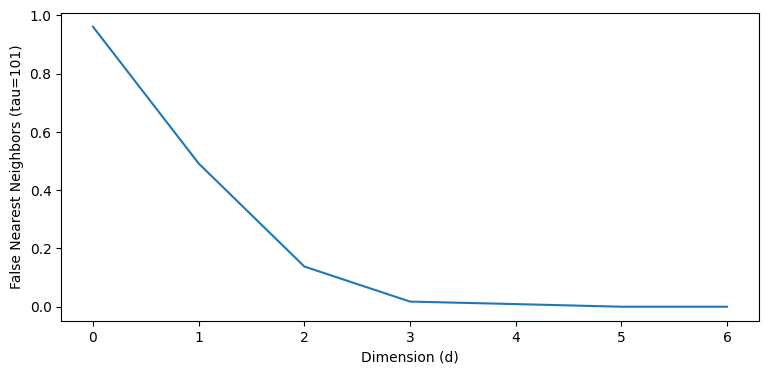

In [49]:
dim = np.arange(1, 8)
f1, f2, f3 = dimension.fnn(df["valor_suavizado"], tau=10, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=101)')
plt.plot(f1)

In [51]:
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded = embedder_periodic.fit_transform(df["valor_suavizado"])


print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (424, 8)


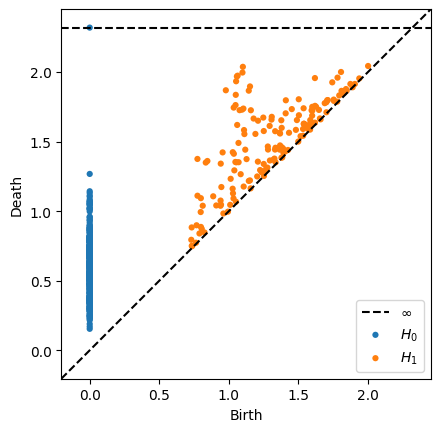

In [52]:
ripsprueba=ripser.ripser(y_periodic_embedded)['dgms']
persim.plot_diagrams(ripsprueba,show=True)

In [53]:
data1 = df[['valor_suavizado','NO3.4']].to_numpy()

In [21]:
data1[44, :]

array([-0.77, 25.99])

In [54]:
mapper1 = km.KeplerMapper(verbose=1)
# La proyección sobre en las variables Número de viajes y tiempo de viajes
projected_data1 = mapper1.fit_transform(data1, projection=[0,1] ) 
covering=km.Cover(n_cubes=3,perc_overlap=0.3)
G1 = mapper1.map(projected_data1, data1, clusterer=sklearn.cluster.KMeans(n_clusters=3),cover=covering)

KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (494, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (494, 2) using lens shaped (494, 2)

Creating 9 hypercubes.

Created 53 edges and 24 nodes in 0:00:00.119984.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [57]:
mapper1.visualize(G1, 
                title='Performance Data based on Año and Niño3.4',
                node_color_function=np.array(['average','std','sum','max','min']))
               

km.jupyter.display("Niño3.4" + ".html")

Wrote visualization to: mapper_visualization_output.html


/usr/local/lib/python3.10/dist-packages/kmapper/visuals.py:344: RuntimeWarning:

invalid value encountered in long_scalars

/usr/local/lib/python3.10/dist-packages/kmapper/visuals.py:345: RuntimeWarning:

invalid value encountered in long_scalars



/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning:

Consider using IPython.display.IFrame instead



In [24]:
max_periodic_dimension=22
max_periodic_time_delay=22
stride=1
tau,d= takens_embedding_optimal_parameters(df["NINO3"], max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)

Optimal time delay:  15 
Optimal dimension:  5


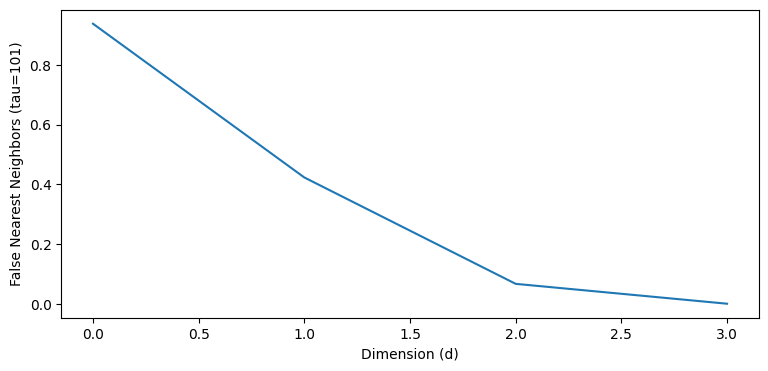

In [25]:
dim = np.arange(1, 5)
f1, f2, f3 = dimension.fnn(df["NINO3"], tau=15, dim=dim)

plt.figure(figsize=(9,4))
plt.xlabel('Dimension (d)')
plt.ylabel('False Nearest Neighbors (tau=101)')
plt.plot(f1)

In [26]:
embedder_periodic = SingleTakensEmbedding(parameters_type="search",time_delay=max_periodic_time_delay,
    dimension=max_periodic_dimension)
y_periodic_embedded2 = embedder_periodic.fit_transform(df["NINO3"])


print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

pca = PCA(n_components=3)
y_periodic_embedded_pca = pca.fit_transform(y_periodic_embedded)
plot_point_cloud(y_periodic_embedded_pca)

Shape of embedded time series: (377, 8)


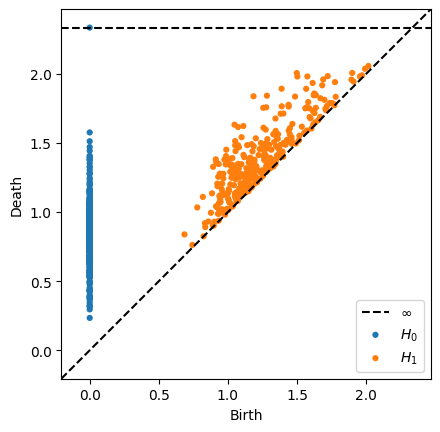

In [27]:
ripsprueba=ripser.ripser(y_periodic_embedded2)['dgms']
persim.plot_diagrams(ripsprueba,show=True)